In [121]:
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn import metrics, linear_model
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit

%matplotlib inline
warnings.filterwarnings("ignore")

In [28]:
df = pd.read_csv('./flight_delay.csv', low_memory=False)
print('Dataframe dimensions:', df.shape)

def df_info(df):
  tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
  tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
  tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100)
                         .T.rename(index={0:'null values (%)'}))
  return tab_info

df_info(df)

Dataframe dimensions: (675513, 5)


,Depature Airport,Scheduled depature time,Destination Airport,Scheduled arrival time,Delay
column type,object,object,object,object,float64
null values (nb),0,0,0,0,0
null values (%),0,0,0,0,0


In [29]:
zero_delay_whole_dataset = (df['Delay']==0).sum()
print(zero_delay_whole_dataset)
print(f"% of zero delays in dataset: {zero_delay_whole_dataset/df.shape[0]*100})")

391070
% of zero delays in dataset: 57.892298149702526)


**Add additional feature - Duration of the flight in minutes & Delayed Fact**

In [30]:
flight_duration = pd.to_datetime(df['Scheduled arrival time']) - pd.to_datetime(df['Scheduled depature time'])
flight_duration = pd.to_timedelta(flight_duration).astype('timedelta64[m]').astype(int)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 675513 entries, 0 to 675512
Data columns (total 5 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Depature Airport         675513 non-null  object 
 1   Scheduled depature time  675513 non-null  object 
 2   Destination Airport      675513 non-null  object 
 3   Scheduled arrival time   675513 non-null  object 
 4   Delay                    675513 non-null  float64
dtypes: float64(1), object(4)
memory usage: 25.8+ MB


In [32]:
# Preprocessing data
df['Duration'] = flight_duration
df['Year'] = pd.DatetimeIndex(df['Scheduled depature time']).year
df['Month'] = pd.DatetimeIndex(df['Scheduled depature time']).month
df['Day'] = pd.DatetimeIndex(df['Scheduled depature time']).day
df['Scheduled depature time'] = pd.to_datetime(df['Scheduled depature time'])
df['Scheduled arrival time'] = pd.to_datetime(df['Scheduled arrival time'])
df['Depature Airport'] = df['Depature Airport'].astype("category")
df['Destination Airport'] = df['Destination Airport'].astype("category")
df['Departure time'] = df['Scheduled depature time'].dt.time
df['IS_delay'] = (df['Delay'] > 0).astype('int')

In [33]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 675513 entries, 0 to 675512
Data columns (total 11 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   Depature Airport         675513 non-null  category      
 1   Scheduled depature time  675513 non-null  datetime64[ns]
 2   Destination Airport      675513 non-null  category      
 3   Scheduled arrival time   675513 non-null  datetime64[ns]
 4   Delay                    675513 non-null  float64       
 5   Duration                 675513 non-null  int64         
 6   Year                     675513 non-null  int64         
 7   Month                    675513 non-null  int64         
 8   Day                      675513 non-null  int64         
 9   Departure time           675513 non-null  object        
 10  IS_delay                 675513 non-null  int64         
dtypes: category(2), datetime64[ns](2), float64(1), int64(5), object(1)
memory usag

,Depature Airport,Scheduled depature time,Destination Airport,Scheduled arrival time,Delay,Duration,Year,Month,Day,Departure time,IS_delay
0,SVO,2015-10-27 07:40:00,HAV,2015-10-27 20:45:00,0.0,785,2015,10,27,07:40:00,0
1,SVO,2015-10-27 09:50:00,JFK,2015-10-27 20:35:00,2.0,645,2015,10,27,09:50:00,1
2,SVO,2015-10-27 10:45:00,MIA,2015-10-27 23:35:00,0.0,770,2015,10,27,10:45:00,0
3,SVO,2015-10-27 12:30:00,LAX,2015-10-28 01:20:00,0.0,770,2015,10,27,12:30:00,0
4,OTP,2015-10-27 14:15:00,SVO,2015-10-27 16:40:00,9.0,145,2015,10,27,14:15:00,1


**Visualization**

**Missing Values**

Now we will check the missing values of the dataset to detect unusable features and when and how are the rest of the missing values meaningful.

In [34]:
def missing_values_checker(dataframe):
  sums = dataframe.isna().sum(axis=0)
  nan_count_limit = 0
  # crate tuples (nan_sum, column_name), filter it and sort it
  non_zero_pairs = sorted([pair for pair in zip(sums, dataframe.columns) if pair[0] > nan_count_limit])
  non_zero_pairs.append((len(dataframe), 'TOTAL'))

  # split tuples into separate lists
  non_zero_sums, non_zero_labels = zip(*non_zero_pairs)
  nans_range = np.asarray(range(len(non_zero_sums)))

  # print info
  for i, (non_zero_sum, non_zero_label) in enumerate(non_zero_pairs):
      print('{}, {}: {}'.format(i, non_zero_label, non_zero_sum))

  # plot info
  plt.figure()
  ax = plt.gca()

  ax.set_xticks(nans_range)
  # ax.set_xticklabels(non_zero_labels)    # set column names in X ticks
  plt.bar(nans_range, non_zero_sums)
  plt.show()

In [35]:
feature_dist = df['Depature Airport'].value_counts()
print(feature_dist)

SVO    336929
LED     19429
AER      9080
SIP      7907
SVX      7757
        ...  
VST         1
BSL         1
NUE         1
TLS         1
SZG         1
Name: Depature Airport, Length: 179, dtype: int64


In [36]:
feature_dist.count()

179

In [37]:
import seaborn as sns
def check_feature_dist(feature_name,data_frame):
  carrier_count = data_frame[f"{feature_name}"].value_counts()
  sns.set(style="darkgrid")
  sns.barplot(carrier_count.index, carrier_count.values, alpha=0.9)
  plt.title(f'Frequency Distribution of {feature_name}')
  plt.ylabel('Number of Occurrences', fontsize=12)
  plt.xlabel(f'{feature_name}', fontsize=12)
  plt.show()

Text(0, 0.5, 'Flight counts')

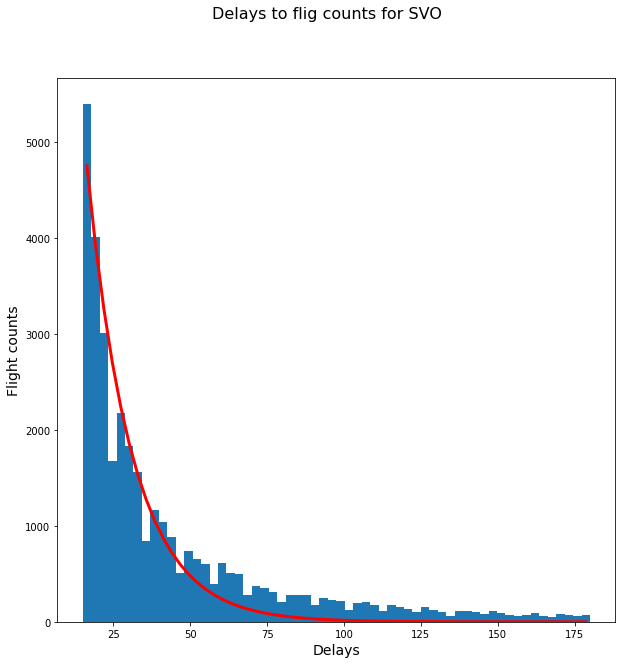

In [38]:
def func(x, a, b):
    return a * np.exp(-x/b)

fig = plt.figure(figsize=(10,10))
n, bins, patches = plt.hist(x = df[df['Depature Airport']=="SVO"]['Delay'], range = (15,180), bins= 60)
bin_centers = bins[:-1] + 0.5 * (bins[1:] - bins[:-1])    
popt, pcov = curve_fit(func, bin_centers, n, p0 = [1, 2])
# draw the fit curve
fig.suptitle('Delays to flig counts for SVO', fontsize=16)
plt.plot(bin_centers, func(bin_centers, *popt), 'r-', linewidth=3, label="fit curve")
plt.xlabel('Delays', fontsize = 14)
plt.ylabel('Flight counts', fontsize = 14)

**Label encoding**

In [39]:
list_categorical_features = df.select_dtypes(include=['object']).columns.to_list()
list_categorical_features.append('Depature Airport')
list_categorical_features.append('Destination Airport')
list_categorical_features

['Departure time', 'Depature Airport', 'Destination Airport']

In [41]:
labels_airport = df['Depature Airport']
lb_make = LabelEncoder()
integer_encoded = lb_make.fit_transform(df['Depature Airport'])
zipped = zip(integer_encoded, df['Depature Airport'])
label_airports = list(set(list(zipped)))
label_airports.sort(key = lambda x:x[0])

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

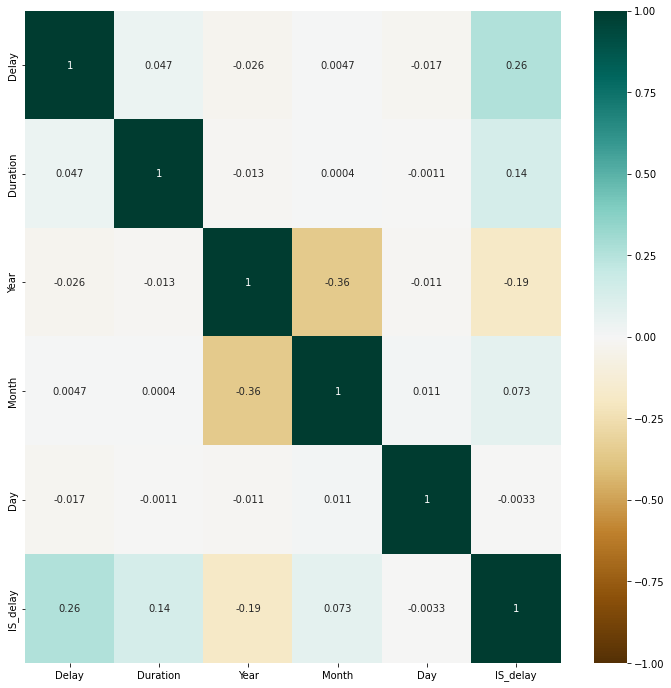

In [42]:
correlations = df.corr()
plt.figure(figsize=(12,12))
sns.heatmap(correlations, center=0, annot=True, vmin=-1, vmax=1, cmap="BrBG")
plt.show()

Text(0.5, 0.98, 'Correlation between Duration and Delay')

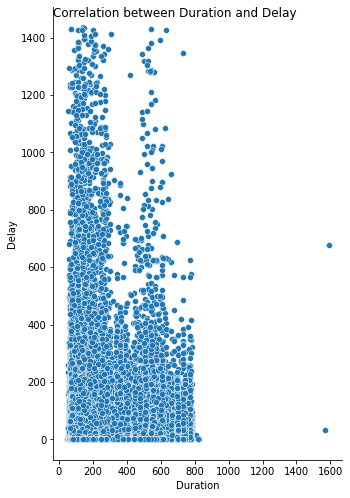

In [43]:
# visualize the relationship between the features and the response using scatterplots
pp = sns.pairplot(df, x_vars=['Duration'], y_vars='Delay', size=7, aspect=0.7)
pp.fig.suptitle("Correlation between Duration and Delay")

In [45]:
df['DATE'] = pd.to_datetime(df[['Year','Month', 'Day']])

In [46]:
df.head()

,Depature Airport,Scheduled depature time,Destination Airport,Scheduled arrival time,Delay,Duration,Year,Month,Day,Departure time,IS_delay,DATE
0,SVO,2015-10-27 07:40:00,HAV,2015-10-27 20:45:00,0.0,785,2015,10,27,07:40:00,0,2015-10-27
1,SVO,2015-10-27 09:50:00,JFK,2015-10-27 20:35:00,2.0,645,2015,10,27,09:50:00,1,2015-10-27
2,SVO,2015-10-27 10:45:00,MIA,2015-10-27 23:35:00,0.0,770,2015,10,27,10:45:00,0,2015-10-27
3,SVO,2015-10-27 12:30:00,LAX,2015-10-28 01:20:00,0.0,770,2015,10,27,12:30:00,0,2015-10-27
4,OTP,2015-10-27 14:15:00,SVO,2015-10-27 16:40:00,9.0,145,2015,10,27,14:15:00,1,2015-10-27


In [48]:
dep_airport = 'SVO'
df2 = df[(df['Depature Airport'] == dep_airport) & (df['Delay'] > 0)]
df2.sort_values('Scheduled depature time', inplace = True)
df2.head()

,Depature Airport,Scheduled depature time,Destination Airport,Scheduled arrival time,Delay,Duration,Year,Month,Day,Departure time,IS_delay,DATE
1,SVO,2015-10-27 09:50:00,JFK,2015-10-27 20:35:00,2.0,645,2015,10,27,09:50:00,1,2015-10-27
12,SVO,2015-10-27 17:10:00,MRV,2015-10-27 19:25:00,14.0,135,2015,10,27,17:10:00,1,2015-10-27
26,SVO,2015-10-27 18:40:00,DXB,2015-10-28 00:25:00,2.0,345,2015,10,27,18:40:00,1,2015-10-27
29,SVO,2015-10-27 18:50:00,WAW,2015-10-27 21:00:00,8.0,130,2015,10,27,18:50:00,1,2015-10-27
106,SVO,2015-10-27 19:05:00,LED,2015-10-27 20:25:00,145.0,80,2015,10,27,19:05:00,1,2015-10-27


In [589]:
df2.head()

,Depature Airport,Scheduled depature time,Destination Airport,Scheduled arrival time,Delay,Duration,Year,Month,Day,DEPARTURE_TIME,IS_delay,DATE
1,144,2015-10-27 09:50:00,68,2015-10-27 20:35:00,2.0,645,2015,10,27,09:50:00,1,2015-10-27
12,144,2015-10-27 17:10:00,98,2015-10-27 19:25:00,14.0,135,2015,10,27,17:10:00,1,2015-10-27
26,144,2015-10-27 18:40:00,36,2015-10-28 00:25:00,2.0,345,2015,10,27,18:40:00,1,2015-10-27
29,144,2015-10-27 18:50:00,172,2015-10-27 21:00:00,8.0,130,2015,10,27,18:50:00,1,2015-10-27
106,144,2015-10-27 19:05:00,84,2015-10-27 20:25:00,145.0,80,2015,10,27,19:05:00,1,2015-10-27


Text(0, 0.5, 'Delay')

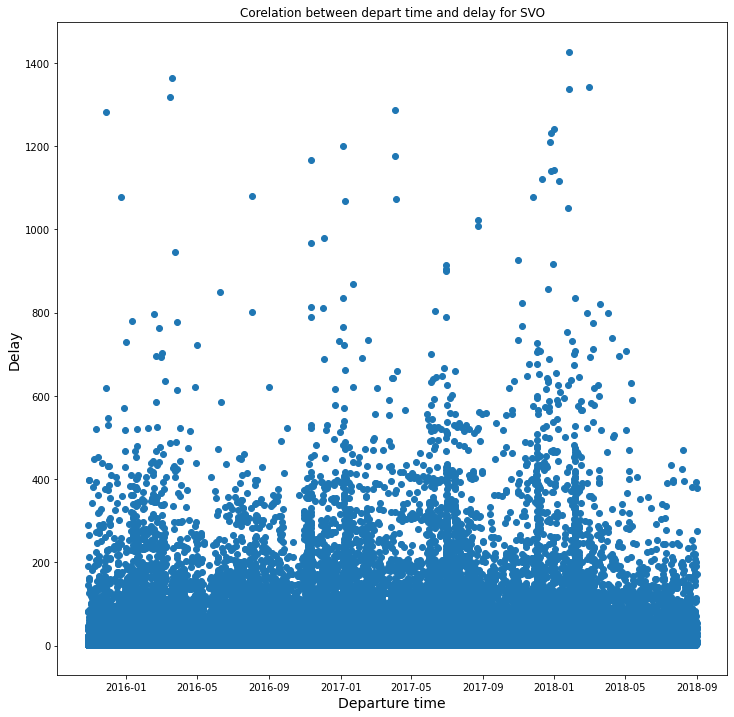

In [56]:
plt.figure(figsize=(12,12))
plt.scatter(df2['Scheduled depature time'], df2['Delay'], label='initial data points')
plt.title("Corelation between depart time and delay for SVO")
plt.xlabel('Departure time', fontsize = 14)
plt.ylabel('Delay', fontsize = 14)

In [58]:
train = df.loc[(df['Year'] <= 2017) & (df['Year'] >=2015)]
test = df.loc[df['Year'] == 2018]

In [59]:
# get only categorical features
cat_df_flights = train.select_dtypes(include=['object']).copy()
cat_df_flights.head()
print(cat_df_flights.columns.to_list())
print(cat_df_flights.isnull().values.sum())
print(cat_df_flights.isnull().sum())

['Departure time']
0
Departure time    0
dtype: int64


In [60]:
train.head()

,Depature Airport,Scheduled depature time,Destination Airport,Scheduled arrival time,Delay,Duration,Year,Month,Day,Departure time,IS_delay,DATE
0,SVO,2015-10-27 07:40:00,HAV,2015-10-27 20:45:00,0.0,785,2015,10,27,07:40:00,0,2015-10-27
1,SVO,2015-10-27 09:50:00,JFK,2015-10-27 20:35:00,2.0,645,2015,10,27,09:50:00,1,2015-10-27
2,SVO,2015-10-27 10:45:00,MIA,2015-10-27 23:35:00,0.0,770,2015,10,27,10:45:00,0,2015-10-27
3,SVO,2015-10-27 12:30:00,LAX,2015-10-28 01:20:00,0.0,770,2015,10,27,12:30:00,0,2015-10-27
4,OTP,2015-10-27 14:15:00,SVO,2015-10-27 16:40:00,9.0,145,2015,10,27,14:15:00,1,2015-10-27


**Remove outliers on delay**

In [65]:
# calculate m
mean = train['Delay'].mean()
print(mean)
# calculate standard deviation
sd = train['Delay'].std()
# determine a threhold
threshold = 2
# detect outlier
train['z_score'] = (train['Delay'] - mean)/sd

train.loc[abs(train['z_score']) > threshold, 'z_score'] = None
train = train.dropna()

6.398472499264249


In [66]:
df_info(train)

,Depature Airport,Scheduled depature time,Destination Airport,Scheduled arrival time,Delay,Duration,Year,Month,Day,Departure time,IS_delay,DATE,z_score
column type,category,datetime64[ns],category,datetime64[ns],float64,int64,int64,int64,int64,object,int64,datetime64[ns],float64
null values (nb),0,0,0,0,0,0,0,0,0,0,0,0,0
null values (%),0,0,0,0,0,0,0,0,0,0,0,0,0


Text(0.5, 0.98, 'Correlation between Duration and Delay')

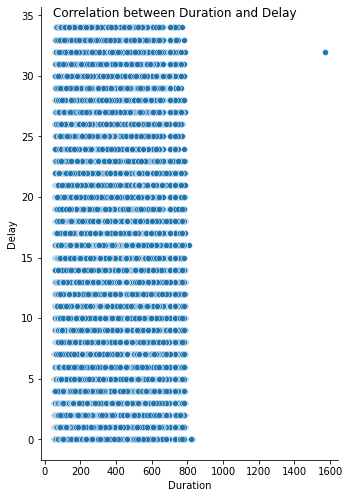

In [68]:
# visualize the relationship between the features and the response using scatterplots
pp = sns.pairplot(train, x_vars=['Duration'], y_vars='Delay', size=7, aspect=0.7)
pp.fig.suptitle("Correlation between Duration and Delay")

In [69]:
from sklearn.linear_model import LinearRegression

In [86]:
lm = linear_model.LinearRegression()
model = lm.fit(train['Duration'].to_numpy().reshape(-1, 1), train['Delay'])
predictions = lm.predict(train['Duration'].to_numpy().reshape(-1, 1))
print("MSE_train =", metrics.mean_squared_error(predictions, train['Delay']))

MSE_train = 44.968572850783


In [87]:
lm = linear_model.LinearRegression()
model = lm.fit(train['Duration'].to_numpy().reshape(-1, 1), train['Delay'])
predictions = lm.predict(test['Duration'].to_numpy().reshape(-1, 1))
print("MSE_test =", metrics.mean_squared_error(predictions, test['Delay']))

MSE_test = 1606.5331876267144


In [84]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [89]:
y_pred = pd.DataFrame(data=predictions).astype('int64')
df_info(y_pred)
print(f"Accuracy score: {accuracy_score(test['Duration'], y_pred=y_pred)}")

Accuracy score: 0.0


In [100]:
poly = PolynomialFeatures(degree = 4)
regr = linear_model.LinearRegression()
X_ = poly.fit_transform(train['Duration'].to_numpy().reshape(-1, 1))
regr.fit(X_, train['Delay'])
result = regr.predict(X_)
print("MSE_train =", metrics.mean_squared_error(result, train['Delay']))

MSE_train = 44.94298288713152


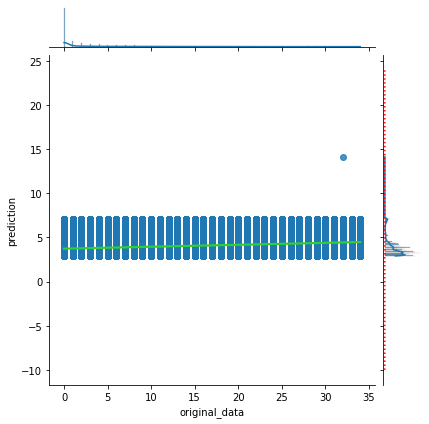

In [102]:
tips = pd.DataFrame()
tips["prediction"] = pd.Series([float(s) for s in result]) 
tips["original_data"] = pd.Series([float(s) for s in train['Delay']]) 
sns.jointplot(x="original_data", y="prediction", data=tips, size = 6, ratio = 7,
              joint_kws={'line_kws':{'color':'limegreen'}}, kind='reg')
plt.xlabel('Mean delays (min)', fontsize = 15)
plt.ylabel('Predictions (min)', fontsize = 15)
plt.plot(list(range(-10,25)), list(range(-10,25)), linestyle = ':', color = 'r')

In [104]:
X_ = poly.fit_transform(test['Duration'].to_numpy().reshape(-1, 1))
result = regr.predict(X_)
score = metrics.mean_squared_error(result, test['Delay'])
print("Mean squared error = ", score)

Mean squared error =  1606.3847413592114


In [107]:
zero_delay_test_dataset = (test['Delay']==0).sum()
print(zero_delay_test_dataset)
print(f"% of zero delays in dataset: {zero_delay_test_dataset/test.shape[0]*100})")

140466
% of zero delays in dataset: 79.60623629222844)


In [112]:
from sklearn.linear_model import Ridge
ridgereg = Ridge(alpha=0.3,normalize=True)
poly = PolynomialFeatures(degree = 4)
X_ = poly.fit_transform(train['Duration'].to_numpy().reshape(-1, 1))
ridgereg.fit(X_, train['Delay'])

Ridge(alpha=0.3, copy_X=True, fit_intercept=True, max_iter=None, normalize=True,
      random_state=None, solver='auto', tol=0.001)

In [123]:
X_ = poly.fit_transform(test['Duration'].to_numpy().reshape(-1, 1))
result = ridgereg.predict(X_)
score = metrics.mean_squared_error(result, test['Delay'])
print("Mean squared error withy regurilization = ", score)
print(f"R2 score{r2_score(test['Delay'], result)}")

Mean squared error withy regurilization =  1607.6429364168957
R2 score-0.003039297208794256


In [117]:
score_min = 10000
for pol_order in range(1, 4):
    for alpha in range(0, 20, 2):
        ridgereg = Ridge(alpha = alpha/10, normalize=True)
        poly = PolynomialFeatures(degree = pol_order)
        regr = linear_model.LinearRegression()
        X_ = poly.fit_transform(train['Duration'].to_numpy().reshape(-1, 1))
        ridgereg.fit(X_, train['Delay'])        
        X_ = poly.fit_transform(test['Duration'].to_numpy().reshape(-1, 1))
        result = ridgereg.predict(X_)
        score = metrics.mean_squared_error(result, test['Delay'])        
        if score < score_min:
            score_min = score
            parameters = [alpha/10, pol_order]
        print("n = {} alpha = {} , MSE = {:<0.5}".format(pol_order, alpha, score))

n = 1 alpha = 0 , MSE = 1606.5
n = 1 alpha = 2 , MSE = 1607.0
n = 1 alpha = 4 , MSE = 1607.3
n = 1 alpha = 6 , MSE = 1607.6
n = 1 alpha = 8 , MSE = 1607.8
n = 1 alpha = 10 , MSE = 1608.0
n = 1 alpha = 12 , MSE = 1608.1
n = 1 alpha = 14 , MSE = 1608.2
n = 1 alpha = 16 , MSE = 1608.3
n = 1 alpha = 18 , MSE = 1608.4
n = 2 alpha = 0 , MSE = 1606.6
n = 2 alpha = 2 , MSE = 1606.7
n = 2 alpha = 4 , MSE = 1606.9
n = 2 alpha = 6 , MSE = 1607.1
n = 2 alpha = 8 , MSE = 1607.3
n = 2 alpha = 10 , MSE = 1607.4
n = 2 alpha = 12 , MSE = 1607.5
n = 2 alpha = 14 , MSE = 1607.7
n = 2 alpha = 16 , MSE = 1607.8
n = 2 alpha = 18 , MSE = 1607.9
n = 3 alpha = 0 , MSE = 1606.4
n = 3 alpha = 2 , MSE = 1606.7
n = 3 alpha = 4 , MSE = 1606.9
n = 3 alpha = 6 , MSE = 1607.0
n = 3 alpha = 8 , MSE = 1607.1
n = 3 alpha = 10 , MSE = 1607.3
n = 3 alpha = 12 , MSE = 1607.4
n = 3 alpha = 14 , MSE = 1607.5
n = 3 alpha = 16 , MSE = 1607.6
n = 3 alpha = 18 , MSE = 1607.6


In [120]:
from sklearn.linear_model import LogisticRegression

logistic_reg = LogisticRegression(penalty='l1', solver='saga')
logistic_reg.fit(train['Duration'].to_numpy().reshape(-1, 1), train['Delay'])

predictions = logistic_reg.predict(train['Duration'].to_numpy().reshape(-1, 1))

score = metrics.mean_squared_error(train['Duration'], predictions)

print("Mean squared error withy regurilization = ", score)

Mean squared error withy regurilization =  52370.75638957563
